In [1]:
import torch
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squidpy as sq
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
import os
import sys
import re
project_root = os.path.dirname(os.path.dirname(os.path.abspath('Pheno.ipynb')))
src_path = os.path.join(project_root, 'src')
sys.path.append(src_path)
plt.style.use('default')
%load_ext autoreload 
%autoreload 2

In [30]:
TNBC_adata = sc.read_h5ad('../data/TNBC_adata/NTImg0001.h5ad')
TNBC_adata

AnnData object with n_obs × n_vars = 290 × 46
    obs: 'BiopsyPhase', 'PatientID', 'ImageNumber', 'ImageID', 'ObjectNumber', 'CellClusters', 'AreaShape_Area', 'isEpithelial', 'Label', 'Colour', 'PrintOrder', 'cellAnnotation', 'SpatialCluster', 'Spatial_Ratio'
    var: 'gene'
    uns: 'spatial_neighbors'
    obsm: 'X_cellcharter', 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [311]:
cells = pd.read_csv('../data/TNBC_raw/cells.csv')
cells

,BiopsyPhase,PatientID,ImageNumber,ImageID,ObjectNumber,CellClusters,AreaShape_Area,isEpithelial,Label,Colour,...,Vimentin,Calponin,Caveolin-1,CD15,MPO,HLA-DR,CD68,pH2AX,CD45,CA9
0,On-treatment,NT008,1,NTImg0001,1,3,40,False,Fibroblasts,#CDAABA,...,1.089647,1.225275,0.000052,0.000003,0.000000e+00,0.000000e+00,3.036761e-06,3.623088e-07,3.530078e-07,0.000004
1,On-treatment,NT008,1,NTImg0001,2,8,97,False,DCs,#FF9400,...,3.668336,0.649361,0.000032,0.000003,1.101167e-06,9.933202e-05,2.987009e-05,2.784882e-07,4.879576e-06,0.000001
2,On-treatment,NT008,1,NTImg0001,4,1,40,False,CA9^+,#750215,...,2.102184,1.287953,0.000050,0.000004,1.525902e-06,5.698302e-06,5.516431e-06,1.869133e-06,6.486504e-07,0.000036
3,On-treatment,NT008,1,NTImg0001,5,1,47,False,CA9^+,#750215,...,2.816998,2.945091,0.000093,0.000002,1.623300e-06,7.971884e-05,3.175431e-05,1.377950e-06,7.120148e-06,0.000085
4,On-treatment,NT008,1,NTImg0001,9,2,31,False,PDPN^+Stromal,#FE99AC,...,0.928723,1.678344,0.000080,0.000001,4.922265e-07,4.890049e-07,9.349693e-07,0.000000e+00,0.000000e+00,0.000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543170,On-treatment,NT091,1889,NTImg1889,1658,6,91,False,Endothelial,#FB321E,...,2.391156,0.551273,0.000090,0.000009,2.179860e-06,7.086111e-05,1.713713e-05,2.406447e-06,9.377881e-06,0.000006
2543171,On-treatment,NT091,1889,NTImg1889,1659,8,73,False,DCs,#FF9400,...,1.088931,0.770366,0.000035,0.000013,2.717360e-06,2.197874e-04,2.553680e-05,1.702265e-06,2.671910e-05,0.000004
2543172,On-treatment,NT091,1889,NTImg1889,1661,3,34,False,Fibroblasts,#CDAABA,...,2.456561,1.183453,0.000031,0.000004,2.692769e-06,1.609981e-05,1.258582e-05,1.266490e-06,1.110854e-05,0.000002
2543173,On-treatment,NT091,1889,NTImg1889,1663,15,38,False,CD4^+PD1^+T,#328A6B,...,0.861024,0.823331,0.000033,0.000032,2.409319e-06,1.040575e-05,5.143531e-06,1.570641e-06,7.016587e-05,0.000001


In [331]:
image_id = (cells[['ImageID']].value_counts() > 360).reset_index().query('count==True')['ImageID'].values
len(image_id)

1762

In [326]:
celltype_mapping = {cells['Label'].astype('category').cat.categories[i]:i for i in range(len(cells['Label'].astype('category').cat.categories))}

In [327]:
celltype_mapping

{'AR^{+}LAR': 0,
 'Apoptosis': 1,
 'Basal': 2,
 'CA9^+': 3,
 'CA9^{+}Hypoxia': 4,
 'CD15^{+}': 5,
 'CD20^+B': 6,
 'CD4^+PD1^+T': 7,
 'CD4^+TCF1^+T': 8,
 'CD56^+NK': 9,
 'CD56^{+}NE': 10,
 'CD79a^+Plasma': 11,
 'CD8^+GZMB^+T': 12,
 'CD8^+PD1^+T_{Ex}': 13,
 'CD8^+T': 14,
 'CD8^+TCF1^+T': 15,
 'CK8/18^{med}': 16,
 'CK^{hi}GATA3^{+}': 17,
 'CK^{lo}GATA3^{+}': 18,
 'DCs': 19,
 'Endothelial': 20,
 'Fibroblasts': 21,
 'Helios^{+}': 22,
 'M2 Mac': 23,
 'MHC I&II^{hi}': 24,
 'Myofibroblasts': 25,
 'Neutrophils': 26,
 'PD-L1^+APCs': 27,
 'PD-L1^+IDO^+APCs': 28,
 'PD-L1^{+}GZMB^{+}': 29,
 'PD-L1^{+}IDO^{+}': 30,
 'PDPN^+Stromal': 31,
 'TCF1^{+}': 32,
 'Treg': 33,
 'Vimentin^{+}EMT': 34,
 'pH2AX^{+}DSB': 35,
 'panCK^{med}': 36}

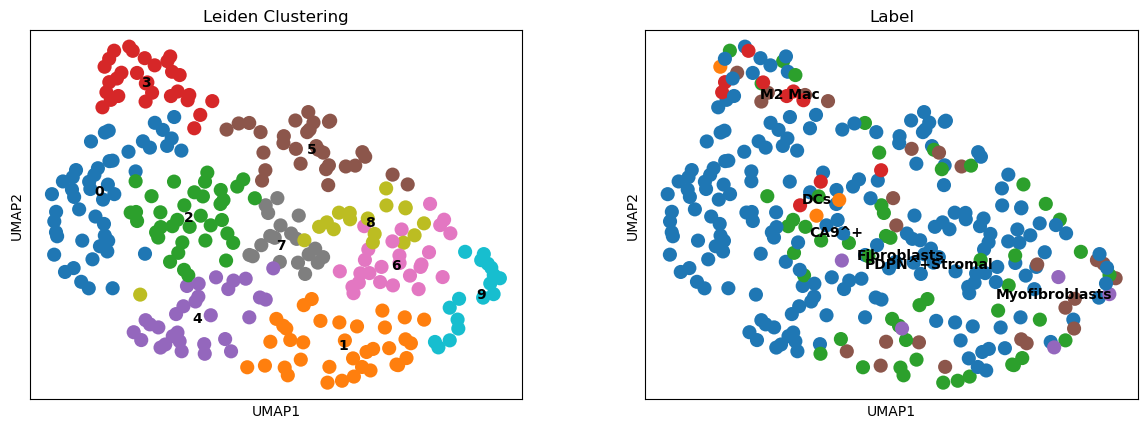

In [345]:
sc.pp.normalize_total(TNBC_adata, target_sum=1e4)
sc.pp.log1p(TNBC_adata)
sc.pp.pca(TNBC_adata)
sc.pp.neighbors(TNBC_adata)
sc.tl.umap(TNBC_adata)
sc.tl.leiden(TNBC_adata)
sc.pl.umap(TNBC_adata, color=['leiden', 'Label'], legend_loc='on data', title='Leiden Clustering')

In [330]:
clinical_data = pd.read_csv('../data/Cleaned_data/TNBC/clinical_data.csv')
clinical_data=clinical_data.query('ImageID in @image_id')
clinical_data

,PatientID,BiopsyPhase,isPerProtocol,pCR,Arm,ImageID
1,NT221,Baseline,True,pCR,C&I,NTImg0603
2,NT221,Baseline,True,pCR,C&I,NTImg0604
3,NT221,Baseline,True,pCR,C&I,NTImg0605
4,NT221,Baseline,True,pCR,C&I,NTImg0606
5,NT221,Baseline,True,pCR,C&I,NTImg0607
...,...,...,...,...,...,...
1585,NT014,On-treatment,True,RD,C&I,NTImg1867
1586,NT014,On-treatment,True,RD,C&I,NTImg1868
1587,NT014,On-treatment,True,RD,C&I,NTImg1869
1588,NT014,On-treatment,True,RD,C&I,NTImg1870


In [332]:
from sklearn.model_selection import train_test_split
train_labels, test_labels = train_test_split(clinical_data, test_size=0.2, random_state=42, stratify=clinical_data['pCR'])

In [333]:
train_labels.to_csv('../data/TNBC_raw/train_labels.csv', index=False)
test_labels.to_csv('../data/TNBC_raw/test_labels.csv', index=False)

In [334]:
cellcat=cells['Label'].astype('category').cat.categories
cellcat = cellcat.values.reshape(-1,1)

In [335]:
encoder = OneHotEncoder()
encoder.fit(cellcat)

OneHotEncoder()

In [336]:
from torch_geometric.data import DataLoader, InMemoryDataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
class GraphDataset(InMemoryDataset):
    def __init__(self, root, adata_dir, label_dir, training=True, transform=None, pre_transform=None):
        self.adata_dir = adata_dir
        self.label_dir = label_dir
        self.training = training
        super(GraphDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [self.label_dir]

    @property
    def processed_file_names(self):
        if self.training:
            return ['training.pt']
        else:
            return ['test.pt']

    def download(self):
        # Download your raw data here, if necessary.
        pass

    def process(self):
        # Read the labels
        labels = pd.read_csv(self.label_dir)
        labels = labels.query('isPerProtocol == True & Arm == "C&I" & BiopsyPhase != "Post-treatment"')
        labels['pCR'] = labels['pCR'].map({'pCR': 1, 'RD': 0})
        remained_images = labels['ImageID'].values
        
        # Create a list of Data objects
        data_list = []
        for image_id in remained_images:
            adata = sc.read_h5ad(f'{self.adata_dir}/{image_id}.h5ad')
            edge_idx, edge_attr = from_scipy_sparse_matrix(adata.obsp['spatial_connectivities'])
            y = labels.query(f'ImageID == "{image_id}"')['pCR'].values[0]
            feature = encoder.transform(adata.obs['Label'].values.reshape(-1, 1))
            feature = torch.tensor(feature.toarray(), dtype=torch.float)
            graph_data = Data(x=feature, edge_index=edge_idx, edge_attr=edge_attr, y=torch.tensor([y], dtype=torch.long))
            data_list.append(graph_data)

        # Process data and store it
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


In [3]:

train_dataset = GraphDataset(root='..', adata_dir='../data/TNBC_adata', label_dir='../data/TNBC_raw/train_labels.csv')
test_dataset = GraphDataset(root='..', adata_dir='../data/TNBC_adata', label_dir='../data/TNBC_raw/test_labels.csv', training=False)

/tmp/ipykernel_65551/1272569341.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
train_dataset = GraphDataset(root='..', adata_dir='../data/TNBC_adata', label_dir='../data/TNBC_raw/train_labels.csv')
test_dataset = GraphDataset(root='..', adata_dir='../data/TNBC_adata', label_dir='../data/TNBC_raw/test_labels.csv', training=False)

train_X = [data.x.numpy().mean(0).reshape(1,-1) for data in train_dataset]
train_y = [data.y.numpy()[0] for data in train_dataset]
test_X = [data.x.numpy().mean(0).reshape(1,-1) for data in test_dataset]
test_y = [data.y.numpy()[0] for data in test_dataset]

train_X = np.concatenate(train_X, axis=0)
test_X = np.concatenate(test_X, axis=0)

clf = RandomForestClassifier(random_state=42)
clf.fit(train_X, train_y)
train_pred = clf.predict(train_X)
test_pred = clf.predict(test_X)
print('Train Accuracy:', accuracy_score(train_y, train_pred))
print('Test Accuracy:', accuracy_score(test_y, test_pred))
print('Classification Report:')
print(classification_report(test_y, test_pred))


/tmp/ipykernel_19349/1458504229.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


Train Accuracy: 0.5699685534591195
Test Accuracy: 0.5628930817610063
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.99      0.70       167
           1       0.88      0.09      0.17       151

    accuracy                           0.56       318
   macro avg       0.71      0.54      0.44       318
weighted avg       0.70      0.56      0.45       318



In [21]:
adata_list = os.listdir('../data/TNBC_adata')
from tqdm import tqdm
for adata in tqdm(adata_list):
    new_ad = sc.read_h5ad(f'../data/TNBC_adata/{adata}')
    sq.gr.spatial_neighbors(new_ad, coord_type='generic', delaunay=True)
    new_ad.write_h5ad(f'../data/TNBC_adata/{adata}')



100%|██████████| 1855/1855 [03:52<00:00,  7.96it/s]


In [25]:
from model import Subgraph
model = Subgraph(gcn_first=16, gcn_second=16, fc_1=32, fc_2=32, cls_hidden=16, number_of_features=TNBC_adata.X.shape[1])

In [202]:
import torch.nn.functional as F
logits = torch.randn(2, 2)
print(logits)

print(F.softmax(logits, dim=1))

tensor([[-0.1188,  0.2047],
        [ 0.1102,  0.4824]])
tensor([[0.4198, 0.5802],
        [0.4080, 0.5920]])


In [240]:
uu= torch.tensor([0, 100], dtype=torch.float32)
F.gumbel_softmax(uu, tau=1, hard=False)

tensor([1.4013e-44, 1.0000e+00])

In [352]:
num_nodes = []
for data in train_dataset:
    num_nodes.append(data.num_nodes)
print(sum(num_nodes)/len(num_nodes))
print(np.std(num_nodes))
print(np.min(num_nodes), np.max(num_nodes))

1379.5936981757877
894.9661216857664
369 10547


In [406]:
import torch
from model import Subgraph
from torch_geometric.data import DataLoader

train_dataset = GraphDataset(root='..', adata_dir='../data/TNBC_adata', label_dir='../data/TNBC_raw/train_labels.csv')
test_dataset = GraphDataset(root='..', adata_dir='../data/TNBC_adata', label_dir='../data/TNBC_raw/test_labels.csv', training=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
# Ensure to adjust root, adata_dir, label_dir to your configurations
# dataset = GraphDataset(root='..', adata_dir='../data/TNBC_adata', label_dir='../data/Cleaned_data/TNBC/clinical_data.csv')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Subgraph(gcn_first=16, gcn_second=16, fc_1=32, fc_2=2, cls_hidden=32, number_of_features=37)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

train_accs = []
test_accs = []
kl_losses = []
cls_losses = []
positive_penalties = []
test_preserve_rate_list = []
train_preserve_rate_list = []
for epoch in range(400):  # Example: 100 epochs
    model.train()
    total_loss = 0
    train_acc_num = 0
    test_acc_num = 0
    train_preserve_rate = 0
    for data in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        _, _, _, kl_loss, cls_loss, positive_penalty, preserve_rate, correct_num = model(data)

        # kl_weight = (1e-4 / 2) * (1 + np.sin(2 * np.pi * (epoch % 40) / 40))
        if epoch < 100:
            loss = cls_loss + kl_loss * 0.000004 + positive_penalty * 5 # Adjust loss composition as needed
        else:
            loss = cls_loss + kl_loss * min(0.00001, 0.00001 * epoch/200) + positive_penalty * 5 # Adjust loss composition as needed
        total_loss += loss
        train_acc_num += correct_num / 2
        loss.backward()
        optimizer.step()
        kl_losses.append(kl_loss.item() * 0.000004)
        cls_losses.append(cls_loss.item())
        positive_penalties.append(positive_penalty.item())
        train_preserve_rate += preserve_rate
    print(f'Train Preserve Rate: {train_preserve_rate / len(train_loader)}')
    train_preserve_rate_list.append(train_preserve_rate / len(train_loader))
    train_acc = train_acc_num / len(train_dataset)
    test_preserve_rate = 0
    for data in test_loader:
        data = data.to(device)
        correct_num, cls_loss, preserve_rate = model.test(data)
        test_acc_num += correct_num
        test_preserve_rate += preserve_rate
    test_preserve_rate_list.append(test_preserve_rate / len(test_loader))
    test_acc = test_acc_num / len(test_dataset)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f'Epoch {epoch}, Loss: {total_loss.item()/len(train_dataset)}, Classification loss: {cls_losses[-1]}, kl_loss: {kl_losses[-1]}, Train Acc: {train_acc}, Test Acc: {test_acc}, Test Preserve Rate: {test_preserve_rate_list[-1]}')

/tmp/ipykernel_3493/1272569341.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])
/home/DingchengYi/miniforge3/

Train Preserve Rate: 0.7070934570653546
Epoch 0, Loss: 0.6021394998477664, Classification loss: 4.876279830932617, kl_loss: 0.009688892578125, Train Acc: 0.5679933665008292, Test Acc: 0.6158940397350994, Test Preserve Rate: 0.15705805041807955
Train Preserve Rate: 0.047071573874879556
Epoch 1, Loss: 0.3418455361133784, Classification loss: 2.646733522415161, kl_loss: 0.015774708984375, Train Acc: 0.5907960199004975, Test Acc: 0.6324503311258278, Test Preserve Rate: 0.020815941540375228
Train Preserve Rate: 0.0032909719776211244
Epoch 2, Loss: 0.2801214316195714, Classification loss: 0.795281171798706, kl_loss: 0.0090506796875, Train Acc: 0.5970149253731343, Test Acc: 0.6556291390728477, Test Preserve Rate: 7.370118322263003e-06
Train Preserve Rate: 1.6213368146708897e-05
Epoch 3, Loss: 0.23587122169102404, Classification loss: 3.3563039302825928, kl_loss: 0.010749599609374999, Train Acc: 0.5941127694859039, Test Acc: 0.6490066225165563, Test Preserve Rate: 1.4032905766017972e-05
Train 

In [407]:
# train_accs = [x.item() for x in train_accs]
# test_accs = [x.item() for x in test_accs]
train_accs = np.array(train_accs)
test_accs = np.array(test_accs)


Text(0.5, 1.0, 'Training and Test Accuracy')

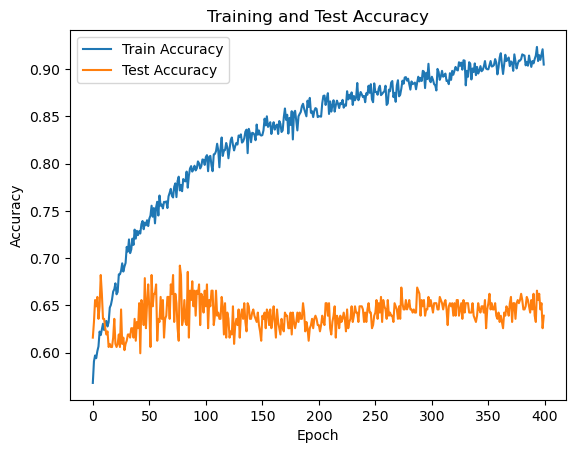

In [408]:
sns.lineplot(x=range(len(train_accs)), y=train_accs, label='Train Accuracy')
sns.lineplot(x=range(len(test_accs)), y=test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')

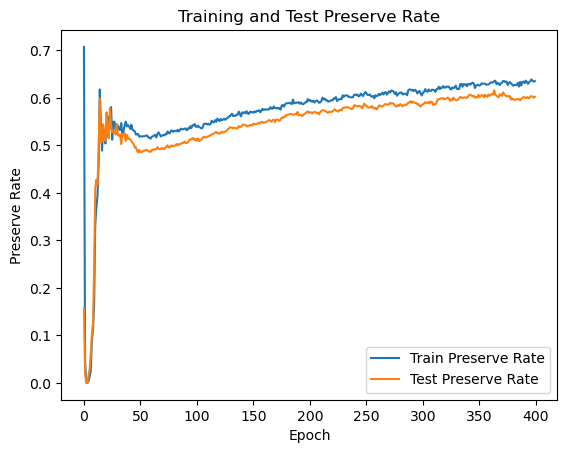

In [409]:
sns.lineplot(x=range(len(train_preserve_rate_list)), y=train_preserve_rate_list, label='Train Preserve Rate')
sns.lineplot(x=range(len(test_preserve_rate_list)), y=test_preserve_rate_list, label='Test Preserve Rate')
plt.xlabel('Epoch')
plt.ylabel('Preserve Rate')
plt.title('Training and Test Preserve Rate')
plt.show()

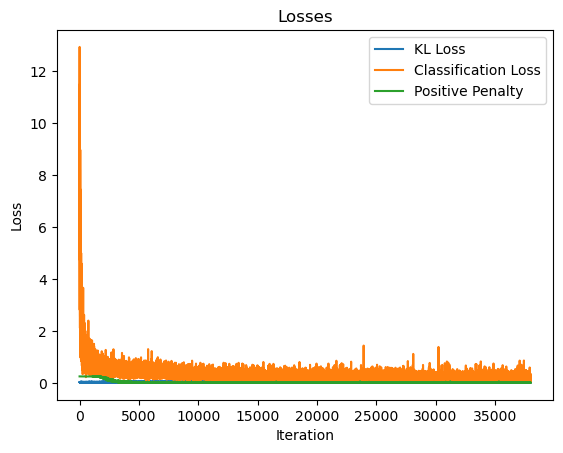

In [396]:
sns.lineplot(x=range(len(kl_losses)), y=kl_losses, label='KL Loss')
sns.lineplot(x=range(len(cls_losses)), y=cls_losses, label='Classification Loss')
sns.lineplot(x=range(len(positive_penalties)), y=positive_penalties, label='Positive Penalty')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()
plt.show()

In [376]:
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='..', name='MUTAG')
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [374]:
num_nodes = []
for data in dataset:
    num_nodes.append(data.num_nodes)
print(sum(num_nodes)/len(num_nodes))
print(np.std(num_nodes))
print(np.min(num_nodes), np.max(num_nodes))

17.930851063829788
4.575664737098715
10 28


In [410]:
from model import Subgraph, BaselineGNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Subgraph(gcn_first=16, gcn_second=16, fc_1=32, fc_2=2, cls_hidden=32, number_of_features=7)

# model = BaselineGNN(gcn_first=32, gcn_second=32, fc_1=64, fc_2=2, cls_hidden=128, number_of_features=7)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

train_accs = []
test_accs = []
cls_losses = []
kl_losses = []
positive_penalties = []
for epoch in range(100):  # Example: 100 epochs
    model.train()
    total_loss = 0
    train_acc_num = 0
    test_acc_num = 0
    train_preserve_rate = 0
    for data in train_loader:
        optimizer.zero_grad()
        data = data.to(device)

        _, _, _, kl_loss, cls_loss, positive_penalty, preserve_rate, correct_num = model(data)
        if epoch < 50:
            loss = cls_loss + positive_penalty
        else:
            loss =  cls_loss + kl_loss* 1 + positive_penalty # Adjust loss composition as needed
        train_acc_num += correct_num / 2
        train_preserve_rate += preserve_rate
        total_loss += loss
        loss.backward()
        optimizer.step()
        cls_losses.append(cls_loss.item())
        kl_losses.append(kl_loss.item())
        positive_penalties.append(positive_penalty.item())
    train_acc = train_acc_num / len(dataset)
    print(f'Train Preserve Rate: {train_preserve_rate / len(train_loader)}')
    train_accs.append(train_acc)
    test_preserve_rate = 0
    for data in train_loader:
        data = data.to(device)
        correct_num, cls_loss, preserve_rate = model.test(data)
        test_preserve_rate += preserve_rate
        test_acc_num += correct_num
    test_acc = test_acc_num / len(dataset)
    test_accs.append(test_acc)
    print(f'Epoch {epoch}, Loss: {total_loss.item()/len(dataset)}, Train Acc: {train_acc}, Test Acc: {test_acc}, Test Preserve Rate: {test_preserve_rate / len(train_loader)}')
    


RuntimeError: mat1 and mat2 shapes cannot be multiplied (21563x37 and 7x32)

Text(0.5, 1.0, 'Training and Test Accuracy')

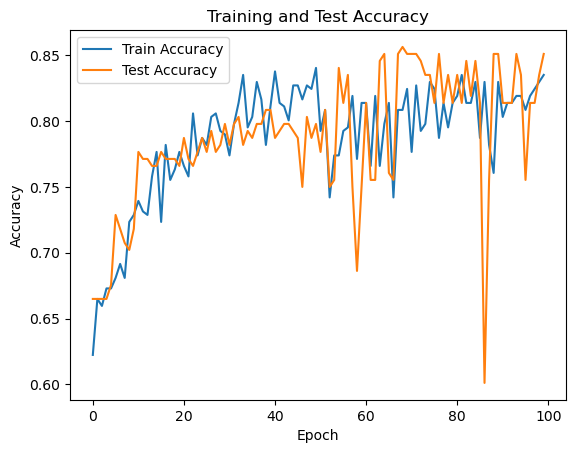

In [378]:
sns.lineplot(x=range(len(train_accs)), y=train_accs, label='Train Accuracy')
sns.lineplot(x=range(len(test_accs)), y=test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')


Text(0.5, 1.0, 'Losses')

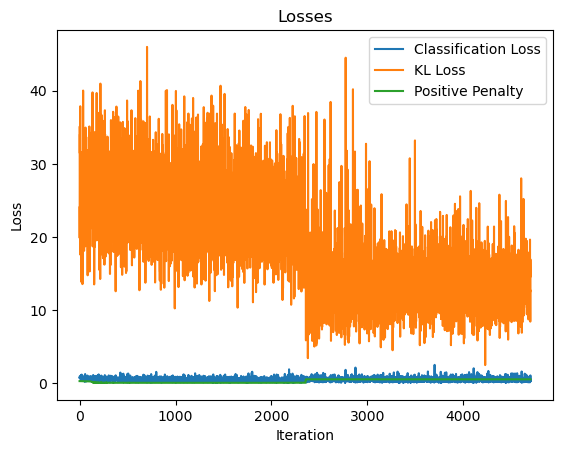

In [379]:
sns.lineplot(x=range(len(cls_losses)), y=cls_losses, label='Classification Loss')
sns.lineplot(x=range(len(kl_losses)), y=kl_losses, label='KL Loss')
sns.lineplot(x=range(len(positive_penalties)), y=positive_penalties, label='Positive Penalty')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Losses')


In [17]:
from model import Subgraph, BaselineGNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = Subgraph(gcn_first=64, gcn_second=16, fc_1=32, fc_2=2, cls_hidden=64, number_of_features=7)

model = BaselineGNN(gcn_first=32, gcn_second=32, fc_1=64, fc_2=2, cls_hidden=128, number_of_features=7)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

train_accs = []
test_accs = []
gradient_accumulation_steps = 8
for epoch in range(100):  # Example: 100 epochs
    model.train()
    total_loss = 0
    train_acc_num = 0
    test_acc_num = 0
    gradient_i = 0
    for data in dataset:
        optimizer.zero_grad()
        data = data.to(device)

        graph_embedding, cls_loss, correct_num, probs = model(data)
        loss =  cls_loss # Adjust loss composition as needed
        train_acc_num += correct_num
        total_loss += loss
        loss.backward()
        optimizer.step()
    train_acc = train_acc_num / len(dataset)
    train_accs.append(train_acc)
    print(f'Epoch {epoch}, Loss: {total_loss.item()/len(dataset)}, Train Acc: {train_acc}')
    


Epoch 0, Loss: 0.6005210064827128, Train Acc: 0.6914893388748169
Epoch 1, Loss: 0.5546687917506441, Train Acc: 0.7180851101875305
Epoch 2, Loss: 0.5301228381217794, Train Acc: 0.7234042286872864
Epoch 3, Loss: 0.5150877769957197, Train Acc: 0.7553191184997559
Epoch 4, Loss: 0.5284293154452709, Train Acc: 0.7553191184997559
Epoch 5, Loss: 0.5176098194528134, Train Acc: 0.7659574151039124
Epoch 6, Loss: 0.5070707848731507, Train Acc: 0.7553191184997559
Epoch 7, Loss: 0.49946898602424783, Train Acc: 0.771276593208313
Epoch 8, Loss: 0.4941808822307181, Train Acc: 0.7659574151039124
Epoch 9, Loss: 0.4890551059804064, Train Acc: 0.7819148898124695
Epoch 10, Loss: 0.48391151428222656, Train Acc: 0.7819148898124695
Epoch 11, Loss: 0.4770393777400889, Train Acc: 0.7872340083122253
Epoch 12, Loss: 0.47356808439214176, Train Acc: 0.7872340083122253
Epoch 13, Loss: 0.47227616005755485, Train Acc: 0.7819148898124695
Epoch 14, Loss: 0.46686898901107465, Train Acc: 0.7819148898124695
Epoch 15, Loss: 

In [372]:
from model import BaselineGNN
from sklearn.metrics import roc_auc_score
from torch_geometric.data import DataLoader
train_dataset = GraphDataset(root='..', adata_dir='../data/TNBC_adata', label_dir='../data/TNBC_raw/train_labels.csv')
test_dataset = GraphDataset(root='..', adata_dir='../data/TNBC_adata', label_dir='../data/TNBC_raw/test_labels.csv', training=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BaselineGNN(gcn_first=16, gcn_second=16, fc_1=32, fc_2=2, cls_hidden=32, number_of_features=37)

# model = Subgraph(gcn_first=16, gcn_second=16, fc_1=32, fc_2=2, cls_hidden=128, number_of_features=37)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
train_accs = []
test_accs = []
for epoch in range(100):  # Example: 100 epochs
    model.train()
    total_loss = 0
    train_acc_num = 0
    test_acc_num = 0
    train_label = []
    train_probs = []
    test_label = []
    test_probs = []
    for data in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        _, loss, correct_num, probs = model(data)
        train_acc_num += correct_num
        total_loss += loss
        loss.backward()
        optimizer.step()
        probs = probs.cpu().detach().numpy()[:, 1]
        train_label.extend(data.y.cpu().numpy())
        train_probs.extend(probs)
    print('Train AUC:', roc_auc_score(train_label, train_probs))
    train_acc = train_acc_num / len(train_dataset)
    for data in test_loader:
        data = data.to(device)
        _, _, correct_num, probs = model(data)
        test_acc_num += correct_num
        probs = probs.cpu().detach().numpy()[:, 1]
        test_probs.extend(probs)
        test_label.extend(data.y.cpu().numpy())
    print('Test AUC:', roc_auc_score(test_label, test_probs))
    test_acc = test_acc_num / len(test_dataset)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f'Epoch {epoch}, Loss: {total_loss.item()/len(train_dataset)}, Train Acc: {train_acc}, Test Acc: {test_acc}')
    


/tmp/ipykernel_3493/1272569341.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])
/home/DingchengYi/miniforge3/

Train AUC: 0.6574449562515152
Test AUC: 0.681133318690973
Epoch 0, Loss: 0.11828458922023995, Train Acc: 0.6086235642433167, Test Acc: 0.6092715263366699
Train AUC: 0.7138551561501334
Test AUC: 0.7135515045025257
Epoch 1, Loss: 0.05393833900565532, Train Acc: 0.6550580263137817, Test Acc: 0.6456953883171082
Train AUC: 0.7279260242875718
Test AUC: 0.7651218976499011
Epoch 2, Loss: 0.04769791180814677, Train Acc: 0.6733001470565796, Test Acc: 0.6986755132675171
Train AUC: 0.7673368523130497
Test AUC: 0.7691631891060839
Epoch 3, Loss: 0.04117929638914801, Train Acc: 0.6898838877677917, Test Acc: 0.7086092829704285
Train AUC: 0.7808939236991161
Test AUC: 0.7778168240720404
Epoch 4, Loss: 0.04060332771162093, Train Acc: 0.711442768573761, Test Acc: 0.6788079738616943
Train AUC: 0.8202510303484452
Test AUC: 0.7855040632549968
Epoch 5, Loss: 0.03488588095897466, Train Acc: 0.7354892492294312, Test Acc: 0.6788079738616943
Train AUC: 0.8458664844731448
Test AUC: 0.8001757083241818
Epoch 6, Loss